In [1]:
# !pip install pandas numpy pip install folium networkx matplotlib

In [93]:
import numpy as np
import pandas as pd
import random
from IPython.display import display


#### Load the matrices

In [94]:
battery_expenditure = pd.read_csv('battery_expenditure_matrix.csv')
distance_matrix = pd.read_csv('distance_matrix.csv')
time_matrix = pd.read_csv('time_matrix.csv')
nodes_csv = pd.read_csv('nodes.csv')

In [95]:
nodes_list =  nodes_csv.values
nodes_list

array([[12.9443978, 77.6514662],
       [12.975668 , 77.6413089],
       [12.9154635, 77.6158909],
       [13.1067756, 77.6005477],
       [13.06002  , 77.5766226],
       [13.0887623, 77.5823852],
       [13.0985096, 77.6273422],
       [13.0686238, 77.4765245],
       [13.0499117, 77.516421 ],
       [13.0757683, 77.4726196],
       [13.0764541, 77.4585122],
       [13.0562923, 77.6328481],
       [13.1180494, 77.5777231],
       [12.9774995, 77.5900342],
       [13.1144798, 77.5677789],
       [12.9767773, 77.5732599],
       [12.9443978, 77.6514662]])

In [96]:
# customer_demands = [[3,4],[5,15],[3,7],[8,7],[6,13]]
# customer_demands = [[3,15],[5,15],[3,15],[8,15],[6,15]]
customer_demands =[[2,15],[2,15],[3,15],[4,15],[5,15]]
# customer_demands = [[3,4],[4,5],[6,7],[8,9],[10,11]]
# customer_demands = [[3,4],[4,5],[5,6],[6,7],[7,8]]


In [97]:
covered_nodes = []

for customer_demand in customer_demands:
    covered_nodes.append(customer_demand[0])
    covered_nodes.append(customer_demand[1])
    sorted(covered_nodes)


#### Generating random combination

In [98]:
num_sequences=20
start_node=0
end_node=16
battery_threshold=10

w1=0.4
w2=0.4
w3=0.2

In [99]:
def quantify_traffic(average_travel_time, traffic_duration):
    traffic_difference = traffic_duration - average_travel_time
    traffic_percentage = (traffic_difference / average_travel_time) * 100
    return (traffic_percentage)


In [100]:
import requests

def get_traffic_value(api_key, orgn_node, dest_node):
    if orgn_node == dest_node: return 0
    origin_lat = nodes_list[orgn_node][0]
    origin_lon = nodes_list[orgn_node][1]
    destination_lat = nodes_list[dest_node][0]
    destination_lon = nodes_list[dest_node][1]
    url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{origin_lon},{origin_lat};{destination_lon},{destination_lat}"
    params = {
        "access_token": api_key,
        "annotations": "duration,distance"
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        traffic_value = data['durations'][0][1]  # Traffic duration from origin to destination in seconds
        average_duration = time_matrix.iloc[orgn_node, dest_node]
        return quantify_traffic(average_duration*60*60,traffic_value)
    else:
        print("Error:", data['message'])
        return None

# Example usage:
api_key = "pk.eyJ1IjoidWpqd2FscmFqNTc5OCIsImEiOiJja3N6dnBpdmIwZ3ZjMnZtc2puaHdtNDFuIn0.aJAMRBRo8FjWxOpmUEyxHw"

# traffic_value = get_traffic_value(api_key, 0 , 15)
# if traffic_value is not None:
#     print("Traffic duration (in seconds):", traffic_value)


In [101]:
def carCapacityMaintained(route):
    curWt = 0
    for i in range(len(route)):
        wt = route[i][1]
        curWt += wt
        if curWt > 3:
            return False
        if curWt < 0:
            return False
         
    return True


In [102]:
def allCustomersDemand(sequence):
    route=[]
    for node in sequence[1:-1]:
        route.append(node[0])
    return sorted(route) == sorted(covered_nodes)

In [103]:
def sequenceIsValid(route):
    # check for validity if every customer reaches destination
    if not allCustomersDemand(route):
        return False

    # check for validity if car strength not increase 3
    if not carCapacityMaintained(route):
        return False
    
    #check if battery level not decrease less than 0
    for i in range(len(route) - 1):
        node1 = route[i][0]
        node2 = route[i + 1][0]
                
        if node1 == 1 or node1 == 2:
            battery_level=78

            battery_consumption = battery_expenditure.iloc[node1, node2]
            battery_level -= battery_consumption
            if battery_level < battery_threshold:
                return False
    return True

In [104]:
def shuffle_array_except_first_last(arr):
    first_element = arr[0]
    last_element = arr[-1]
    internal_elements = arr[1:-1]
    random.shuffle(internal_elements)
    shuffled_array = [first_element] + internal_elements + [last_element]
    return shuffled_array

In [105]:
def generate_random_sequences(num_sequences,customer_demands=customer_demands):
    sequences = []

    for _ in range(num_sequences):
        while True:
            route = [(0, 0) for _ in range(12)]
            used_positions = set()
            unused_positions = set()
            for i in range(12):
                unused_positions.add(i)
            unused_positions.remove(0)
            unused_positions.remove(11)
            used_positions.add(0)
            used_positions.add(11)

            for demand in customer_demands:
                position1 = random.randint(min(unused_positions),max(unused_positions)-1)
                while position1 in used_positions:
                    position1 = random.randint(min(unused_positions),max(unused_positions)-1)
                unused_positions.remove(position1)
                used_positions.add(position1)

                position2 = random.randint(position1 + 1, max(unused_positions))
                while position2 in used_positions:
                    position2 = random.randint(position1 + 1, max(unused_positions))
                unused_positions.remove(position2)
                used_positions.add(position2)

                route[position1] = (demand[0], +1)  # Insert the start node of the customer demand
                route[position2] = (demand[1], -1)  # Insert the end node of the customer demand

            
            if sequenceIsValid(route):
                sequences.append(route)
                break

    return sequences

In [106]:
random_seq=generate_random_sequences(num_sequences)
# random_seq

In [107]:
def calculate_cost(sequence, time_matrix, distance_matrix, w1, w2):
    cost1 = 0
    cost2 = 0
    cost = 0

    for i in range(len(sequence) - 1):
        node1 = sequence[i][0]
        node2 = sequence[i + 1][0]

        cost1 += time_matrix.iloc[node1, node2]
        cost2 += distance_matrix.iloc[node1, node2]
        cost += (w1 * time_matrix.iloc[node1, node2]) + (w2 * distance_matrix.iloc[node1, node2]) + (w3* 89)

    return pd.DataFrame({'Σt': [cost1], 'Σd': [cost2], 'w1*Σt+w2*Σd+w3*Σtraffic': [cost]})

In [108]:
cost_for_each_sequence = [calculate_cost(sequence, time_matrix, distance_matrix, w1, w2) for sequence in random_seq]
result_df = pd.concat(cost_for_each_sequence, ignore_index=True)

In [109]:
result_df

,Σt,Σd,w1*Σt+w2*Σd+w3*Σtraffic
0,2.762583,121.3115,186.819927
1,2.549083,112.4093,187.112810
2,2.850028,125.8270,209.306246
3,2.979972,132.4960,226.800040
4,3.123972,138.2967,216.245207
5,2.843083,126.8519,178.461694
6,3.273972,146.9386,218.148924
7,3.020528,133.5495,228.693498
8,3.140722,141.9549,220.178346
9,3.521139,158.2766,229.504969


## Genetic Algorithm implementation

In [110]:
def initialize_population(population_size):
    population = generate_random_sequences(population_size)
    return population


In [111]:
def tournament_selection(population, fitness_values, tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        winner_index = tournament_indices[np.argmin(tournament_fitness)]
        selected_parents.append(population[winner_index])
    return selected_parents

In [113]:
def cyclic_shift(lst, positions):
    length = len(lst)
    positions = positions % length  # Ensure positions is within the range of list length
    return lst[-positions:] + lst[:-positions]

In [114]:
import random
#Redo
def ordered_crossover(parent1, parent2):
    parent1= parent1[1:-1]
    parent2= parent2[1:-1]

    crossover_points = sorted(random.sample(range(1, len(parent1)), 2))
    while True:
        offspring = parent2[crossover_points[0]:crossover_points[1]]
        remaining =[]
        for i in parent1[crossover_points[1]:]:
            if offspring.count(i) + remaining.count(i) < parent1.count(i):
                remaining.append(i)
        
        
        for i in parent1[0:crossover_points[1]]:
            if offspring.count(i) + remaining.count(i) < parent1.count(i):
                remaining.append(i)
        
        offspring = offspring + remaining
        offspring = cyclic_shift(offspring,crossover_points[0])

        offspring= [(0,0)] + offspring + [(0,0)]
        if sequenceIsValid(offspring):
            break
        
        crossover_points = sorted(random.sample(range(1, len(parent1)), 2))

    parent1= [(0,0)] + parent1 + [(0,0)]
    parent2= [(0,0)] + parent2 + [(0,0)]
    return offspring


In [115]:
def inversion_mutation(sequence):
    randPnts = sorted(random.sample(range(1, len(sequence)-2), 2))
    # print("Org: ",sequence)
    while True:
        start = randPnts[0]
        end = randPnts[1]
        
        mutated_sequence = sequence[:start] + list(reversed(sequence[start:end+1])) + sequence[end+1:]
        if sequenceIsValid(mutated_sequence):
            break
        randPnts = sorted(random.sample(range(1, len(sequence)-2), 2))
    # print("Mut: ",mutated_sequence)
    return mutated_sequence

In [119]:
import random
fitness_values_y_coordinates = []

def genetic_algorithm(num_generations, population_size, tournament_size,crossover_probability ,mutation_probability):
    population = initialize_population(population_size)
    # display(pd.DataFrame(population))
    for generation in range(num_generations):
        fitness_values = [calculate_cost(sequence, time_matrix, distance_matrix, w1, w2)['w1*Σt+w2*Σd+w3*Σtraffic'].values[0] for sequence in population]
        
        parents = tournament_selection(population, fitness_values, tournament_size)
        print(len(parents), population_size)
        random.shuffle(parents)
        offspring = []

        for i in range(0, len(parents), 2):
            if i + 1 < len(parents):
                if random.uniform(0, 1) < crossover_probability:
                    child1 = ordered_crossover(parents[i], parents[i + 1])
                    child2 = ordered_crossover(parents[i + 1], parents[i])
                else:
                    child1 = parents[i]
                    child2 = parents[i + 1]
                    # print(child1)
                    # offspring.extend([child1, child2])
                offspring.append(child1)
                offspring.append(child2)


        mutated_offspring = []
        for child in offspring:
            if random.uniform(0, 1) < mutation_probability:
                mutated_child = inversion_mutation(child)
                mutated_offspring.append(mutated_child)
            else:
                mutated_offspring.append(child)

        population = mutated_offspring
        current_best_sequence = min(population, key=lambda x: calculate_cost(x, time_matrix, distance_matrix, w1, w2)['w1*Σt+w2*Σd+w3*Σtraffic'].values[0])
        current_min_fitness = calculate_cost(current_best_sequence, time_matrix, distance_matrix, w1, w2).iloc[-1,-1]
        fitness_values_y_coordinates.append(current_min_fitness)

    best_sequence = min(population, key=lambda x: calculate_cost(x, time_matrix, distance_matrix, w1, w2)['w1*Σt+w2*Σd+w3*Σtraffic'].values[0])
    
    return best_sequence,population


In [120]:

best_sequence,final_population = genetic_algorithm(num_generations=100, population_size=50, tournament_size=5, crossover_probability=0.95,mutation_probability=0.03)
print("Best Sequence:", best_sequence)
costdf = calculate_cost(best_sequence, time_matrix, distance_matrix, w1, w2)
display(costdf)
print("Best Cost:",costdf.iloc[-1,-1])


In [23]:
cost_for_each_sequence = [calculate_cost(sequence, time_matrix, distance_matrix, w1, w2) for sequence in final_population]
result_df = pd.concat(cost_for_each_sequence, ignore_index=True)
result_df = result_df.drop_duplicates()
print(result_df.shape[0])

3


### Convergence curve

In [24]:
import matplotlib.pyplot as plt

def plot_GA_Convergence_curve(x_values, y_values, xlabel="Generation", ylabel="Fitness Value", title="GA convergence curve"):
    plt.plot(x_values, y_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

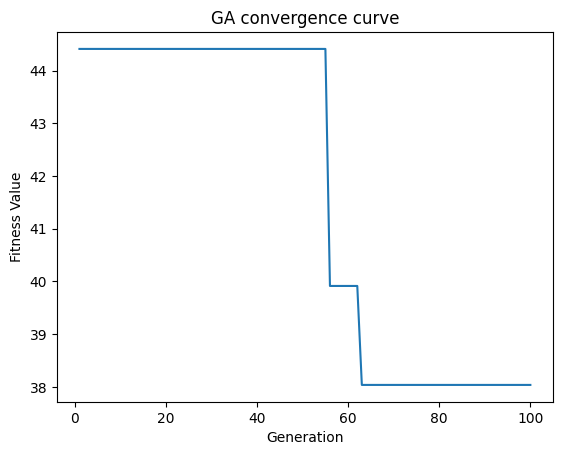

In [25]:
x_values = []
for i in range (1,101):
    x_values.append(i)
plot_GA_Convergence_curve(x_values,fitness_values_y_coordinates)

In [26]:
result_df

,Σt,Σd,w1*Σt+w2*Σd
0,1.763750,74.3125,38.038125
22,2.275167,99.9396,51.107383
33,2.277944,100.0155,51.146722


In [27]:
final_population_list=final_population
final_population=pd.DataFrame(final_population).drop_duplicates()
display(final_population)


,0,1,2,3,4,5,6,7,8,9,10,11
0,"(0, 0)","(2, 1)","(2, 1)","(15, -1)","(15, -1)","(4, 1)","(5, 1)","(3, 1)","(15, -1)","(15, -1)","(15, -1)","(0, 0)"
22,"(0, 0)","(2, 1)","(2, 1)","(15, -1)","(4, 1)","(15, -1)","(5, 1)","(3, 1)","(15, -1)","(15, -1)","(15, -1)","(0, 0)"
33,"(0, 0)","(2, 1)","(2, 1)","(15, -1)","(15, -1)","(4, 1)","(15, -1)","(3, 1)","(5, 1)","(15, -1)","(15, -1)","(0, 0)"


In [28]:
coord=[(12.975668, 77.6413089),
       (12.9154635, 77.6158909),
       (12.9443978, 77.6514662),
       (13.1067756, 77.6005477),
        (13.06002, 77.5766226),
        (13.0887623, 77.5823852),
        (13.0985096, 77.6273422),
        (13.0686238, 77.4765245),
        (13.0499117, 77.516421),
        (13.0757683, 77.4726196),
        (13.0764541, 77.4585122),
        (13.0562923, 77.6328481),
        (13.1180494, 77.5777231),
        (12.9774995, 77.5900342),
        (13.1144798, 77.5677789),
        (12.9767773, 77.5732599),
        (12.975668, 77.6413089)]

def plot_data_from_sequence(sequence):
    cities_data=[]
    for sq in sequence:
        node = sq[0]
        cust = sq[1]
        coordinate = coord[node]
        cities_data.append([node,coordinate,cust])
    return cities_data
        

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_node_sequence(node_sequence):
    G = nx.Graph()

    for i in range(len(node_sequence) - 1):
        node_a, coords_a, action_a = node_sequence[i]
        node_b, coords_b, action_b = node_sequence[i + 1]
        G.add_node(node_a, pos=coords_a, action=action_a)
        G.add_node(node_b, pos=coords_b, action=action_b)
        G.add_edge(node_a, node_b, weight=1) 

    pos = nx.get_node_attributes(G, 'pos')
    node_actions = nx.get_node_attributes(G, 'action')

    # Draw nodes with different colors based on actions
    node_colors = [node_actions[node] for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color=node_colors, cmap=plt.cm.RdYlBu, font_color='black', font_size=8, width=2)

    plt.show()

In [30]:
best_sequence_data=plot_data_from_sequence(best_sequence)
best_sequence_data

[[0, (12.975668, 77.6413089), 0],
 [2, (12.9443978, 77.6514662), 1],
 [2, (12.9443978, 77.6514662), 1],
 [15, (12.9767773, 77.5732599), -1],
 [15, (12.9767773, 77.5732599), -1],
 [4, (13.06002, 77.5766226), 1],
 [5, (13.0887623, 77.5823852), 1],
 [3, (13.1067756, 77.6005477), 1],
 [15, (12.9767773, 77.5732599), -1],
 [15, (12.9767773, 77.5732599), -1],
 [15, (12.9767773, 77.5732599), -1],
 [0, (12.975668, 77.6413089), 0]]

Best Sequence:  [(0, 0), (2, 1), (2, 1), (15, -1), (15, -1), (4, 1), (5, 1), (3, 1), (15, -1), (15, -1), (15, -1), (0, 0)]
Best Cost:  38.038124999999994


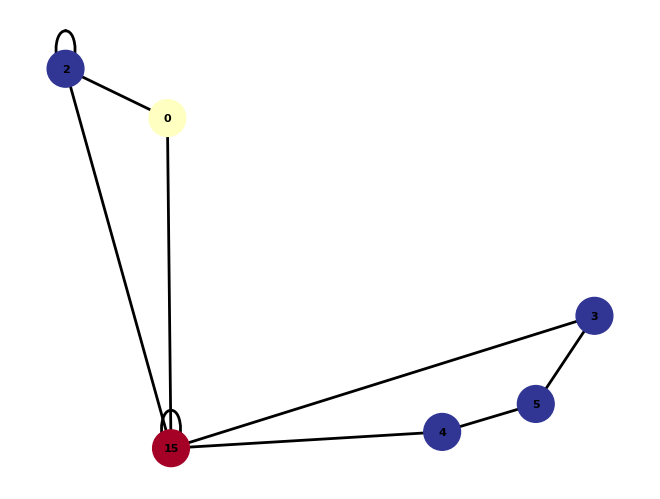

In [31]:
# temp_cost=calculate_cost([(0, 0), (3, 1), (4, -1), (4, 1), (5, -1), (5, 1), (6, -1), (6, 1), (7, -1), (7, 1), (8, -1), (0, 0)],time_matrix,distance_matrix,0.5,0.5)
# print(temp_cost)
print("Best Sequence: ",best_sequence)
print("Best Cost: ",costdf.iloc[-1,-1])
plot_node_sequence(best_sequence_data)

In [32]:
# for seq in final_population_list:
#     print("Sequence: ",seq)
#     plot_node_sequence(plot_data_from_sequence(seq))

In [33]:
pip install scipy



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import random

def generate_random_sign():
    # Generate a random integer (0 or 1)
    random_int = random.randint(0, 1)
    
    # Map 0 to -1 and 1 to 1
    return 1 if random_int == 1 else -1

def get_value_from_map(data_map, key):
    # Use dict.get() to retrieve the value with a default of 0
    return data_map.get(key, 0)



# Flower Pollen Algorithm


In [36]:
import random
import numpy as np
import math
from scipy.special import gamma

def flower_pollination_algorithm(population_size, max_generations, self_pollination_probability, gamma, beta):
    population = generate_random_sequences(population_size)

    for generation in range(max_generations):
        fitness = [fitness_function(sequence) for sequence in population]

        sorted_population = [x for _, x in sorted(zip(fitness, population), key=lambda pair: pair[0])]

        for i in range(population_size):
            if random.random() < self_pollination_probability:
                print('noo')
                # Self-pollination
                pollinator_index1 = i
                pollinator_index2 = i
                while pollinator_index1 is not i and pollinator_index2 is not i:
                    pollinator_indexes = random.randint(0, population_size - 1)
                    pollinator_index1, pollinator_index2 = pollinator_indexes

                new_solution = self_pollination(sorted_population[i],sorted_population[pollinator_index1],sorted_population[pollinator_index2], gamma)
                new_solution= convert_to_numbers(new_solution)
                print("Before Self Pollination: ", sorted_population[i])
                print("After Self Pollination: ", new_solution)
            else:
                # Cross-pollination
                # Randomly choose a flower to be the pollinator
                pollinator_index = random.randint(0, population_size - 1)
                new_solution = cross_pollination(sorted_population[i], sorted_population[pollinator_index], beta)
                new_solution= convert_to_numbers(new_solution)
                print("Before Cross Pollination: ", sorted_population[i], sorted_population[pollinator_index])
                print("After Cross Pollination: ", new_solution)

            # while not sequenceIsValid(new_solution):
            #     repaired_sequence = repair_sequence(new_solution)
            #     new_solution = repaired_sequence

            # If the new solution is valid and better, replace the old solution
            # if fitness_function(new_solution) < fitness_function(population[i]):
            #     population[i] = new_solution

    best_solution = min(population, key=fitness_function)
    return best_solution


customer_demand_count = {}
node_count = {}

for demand in customer_demands:
    node_count[demand[0]]=0
    node_count[demand[1]]=0
    customer_demand_count[demand[0]]=[0,0]
    customer_demand_count[demand[1]]=[0,0]

for demand in customer_demands:
    node_count[demand[0]]+=1
    node_count[demand[1]]+=1
    customer_demand_count[demand[0]][0]+=1
    customer_demand_count[demand[1]][1]+=1



print("Customer: ",customer_demands)
print("Customer demand count: ",customer_demand_count)
    

def repair_sequence(new_solution):
    cur_cap = 0
    picked_up = {}
    repaired_sol = []
    for soln in new_solution:
        if soln[0] == 0:
            repaired_sol.append((0,0))
            continue

        if get_value_from_map(picked_up,soln[0])==0 and cur_cap<3:
            repaired_sol.append((soln[0],+1))
            picked_up[soln[0]]+=1
            cur_cap+=1
        
        if 
            

    

    return new_solution


def self_pollination(xt_i, xt_j, xt_k, k=1e-20):
    xt_i_list = [s[0] for s in xt_i]
    xt_j_list = [s[0] for s in xt_j]
    xt_k_list = [s[0] for s in xt_k]
    # (xt_j - xt_k)
    difference = [str(xj - xk) for xj, xk in zip(xt_j_list, xt_k_list)]
    # Generate a random number from a uniform distribution
    epsilon = np.random.uniform(0, 1)
    # Calculate the product: k * epsilon * (xt_j - xt_k)
    product = [int(k * epsilon * int(diff)) for diff in difference]
    # Add the product to the current solution
    new_solution = [str(xi + p) for xi, p in zip(xt_i_list, product)]
    return new_solution

def cross_pollination(g_star, xt_i, gamma=1e-1, step_length=5):
    g_star_list = [s[0] for s in g_star]
    xt_i_list = [s[0] for s in xt_i]
    # (g* - xt_i)
    difference = [str(g - xi) for g, xi in zip(g_star_list, xt_i_list)]
    # Calculate the product: gamma * step_length * (g* - xt_i)
    product = [int(gamma * levy_distribution() * int(diff)) for diff in difference]
    # Add the product to the current solution
    new_solution = [str(xi + p) for xi, p in zip(xt_i_list, product)]
    return new_solution

def levy_distribution(lmbda=1.5, s1=5):
    pi_value = math.pi
    numerator = lmbda * gamma(lmbda) * math.sin(pi_value * lmbda / 2)
    denominator = pi_value * (1 / s1 + lmbda)
    result = numerator / denominator
    return result


def fitness_function(sequence):
    return calculate_cost(sequence, time_matrix, distance_matrix, w1, w2).iloc[-1,-1]

def convert_to_numbers(str_list):
    return [[int(num_str),0] for num_str in str_list]


Customer:  [[2, 15], [2, 15], [3, 15], [4, 15], [5, 15]]
Customer demand count:  {2: [2, 0], 15: [0, 5], 3: [1, 0], 4: [1, 0], 5: [1, 0]}


In [35]:
print(flower_pollination_algorithm(50,50,0.1,0.1,0.1))

Before Cross Pollination:  [(0, 0), (5, 1), (4, 1), (3, 1), (15, -1), (15, -1), (2, 1), (2, 1), (15, -1), (15, -1), (15, -1), (0, 0)] [(0, 0), (4, 1), (5, 1), (15, -1), (15, -1), (3, 1), (2, 1), (15, -1), (15, -1), (2, 1), (15, -1), (0, 0)]
After Cross Pollination:  [[0, 0], [4, 0], [5, 0], [15, 0], [15, 0], [3, 0], [2, 0], [15, 0], [15, 0], [2, 0], [15, 0], [0, 0]]
Before Cross Pollination:  [(0, 0), (4, 1), (5, 1), (15, -1), (15, -1), (3, 1), (2, 1), (2, 1), (15, -1), (15, -1), (15, -1), (0, 0)] [(0, 0), (5, 1), (15, -1), (4, 1), (15, -1), (3, 1), (15, -1), (2, 1), (15, -1), (2, 1), (15, -1), (0, 0)]
After Cross Pollination:  [[0, 0], [5, 0], [15, 0], [4, 0], [15, 0], [3, 0], [15, 0], [2, 0], [15, 0], [2, 0], [15, 0], [0, 0]]
Before Cross Pollination:  [(0, 0), (3, 1), (5, 1), (4, 1), (15, -1), (2, 1), (15, -1), (15, -1), (15, -1), (2, 1), (15, -1), (0, 0)] [(0, 0), (2, 1), (3, 1), (15, -1), (2, 1), (5, 1), (15, -1), (15, -1), (4, 1), (15, -1), (15, -1), (0, 0)]
After Cross Pollinati